In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



In [ ]:
import os
print(os.getcwd())  # Prints the current working directory


/content


In [ ]:
# Load dataset
df = pd.read_csv("nvidia_stock_prices.csv")



In [ ]:
df.describe()
df.shape

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
print("Missing values:")

print(df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

# Summary statistics
print(df.describe())

Missing values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Duplicates: 0
              Open         High          Low        Close        Volume
count  5033.000000  5033.000000  5033.000000  5033.000000  5.033000e+03
mean      5.214671     5.308604     5.117086     5.217039  5.587962e+08
std       9.643976     9.811276     9.465058     9.644928  3.363408e+08
min       0.080583     0.083917     0.077500     0.078583  4.564400e+07
25%       0.344000     0.349000     0.336500     0.343250  3.482920e+08
50%       0.544000     0.552750     0.532500     0.542000  4.910920e+08
75%       5.233750     5.296500     5.125000     5.229000  6.816760e+08
max      50.216000    50.548000    49.411999    50.409000  5.088948e+09


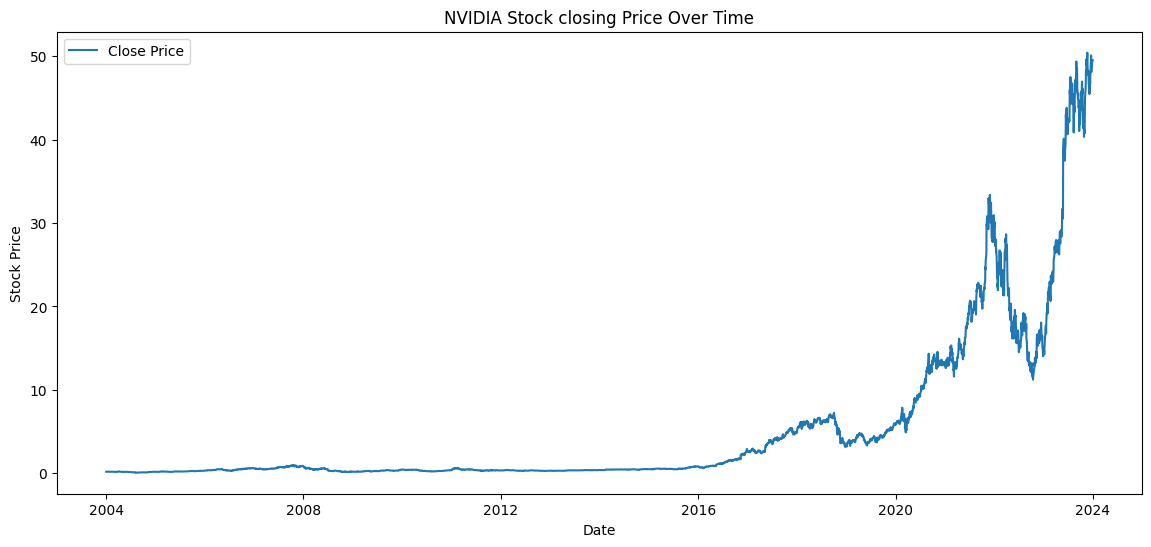

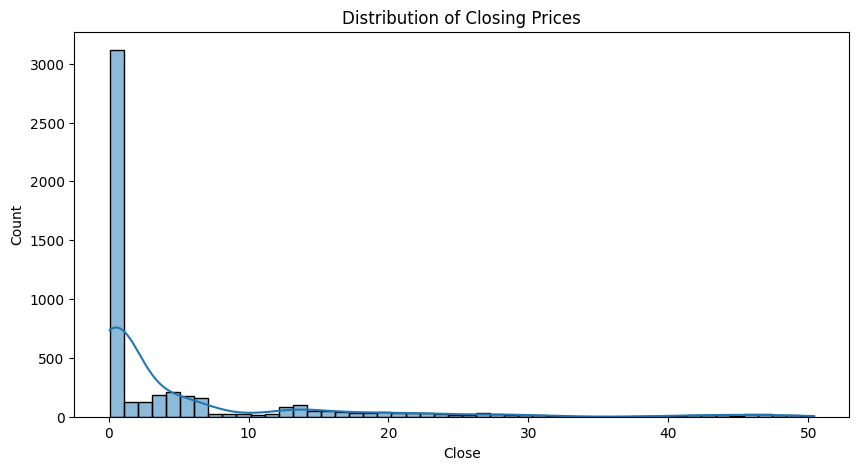

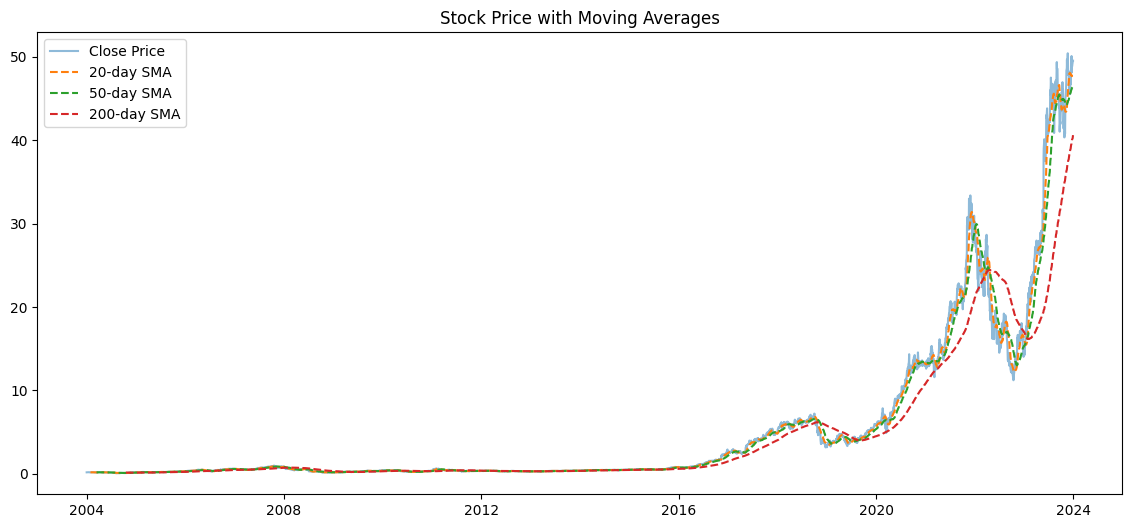

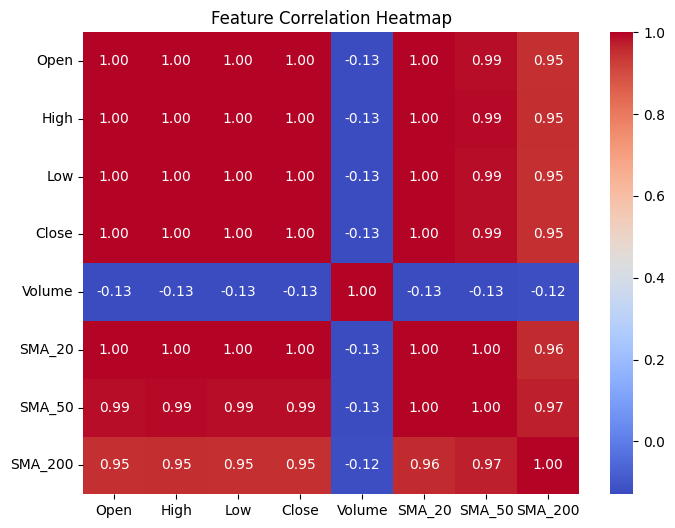

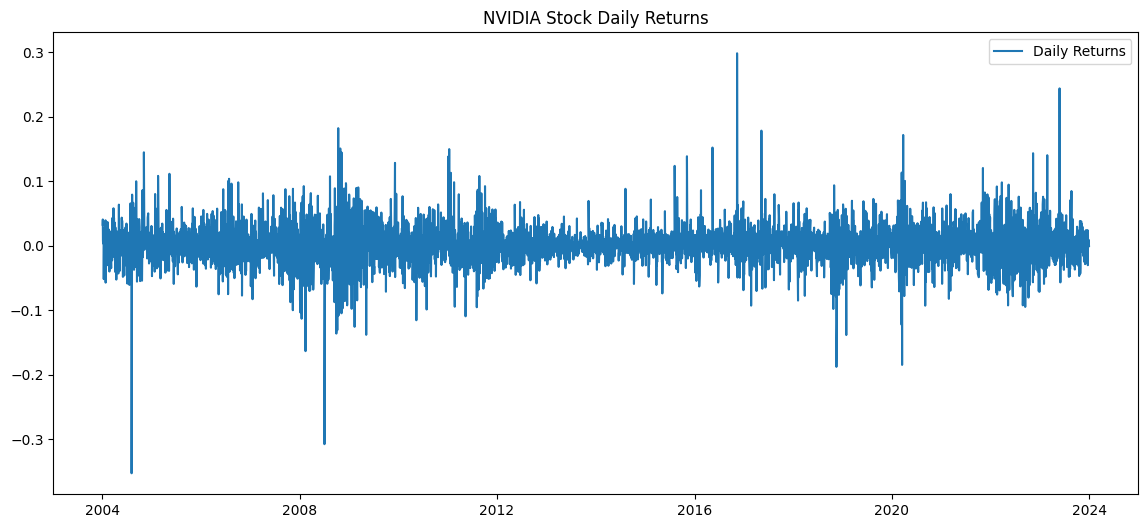

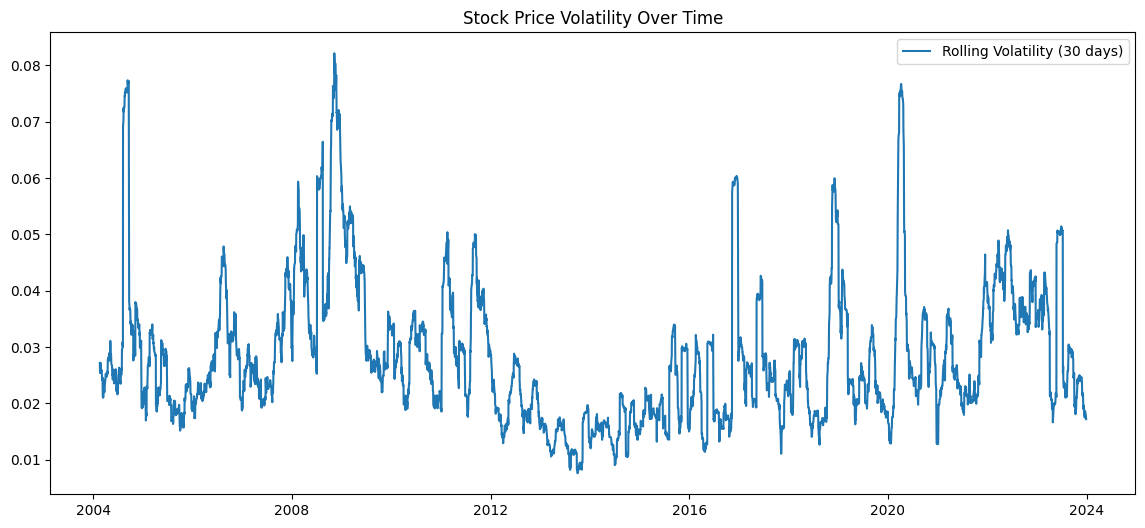

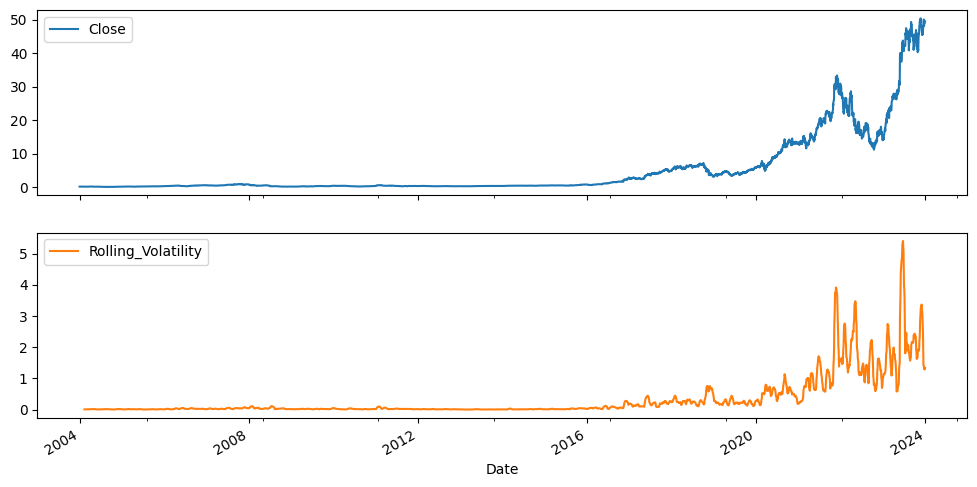

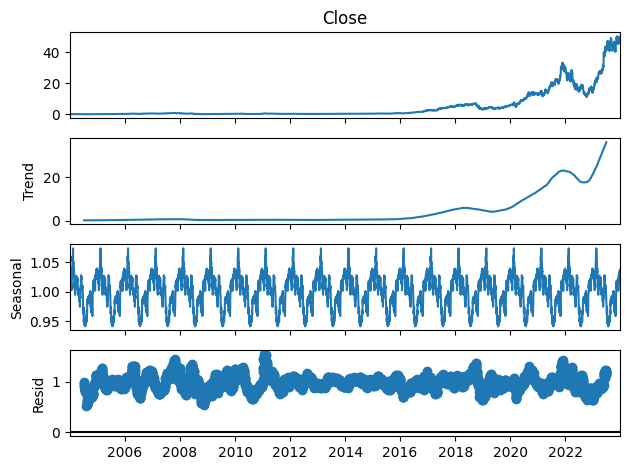

<Figure size 1400x600 with 0 Axes>

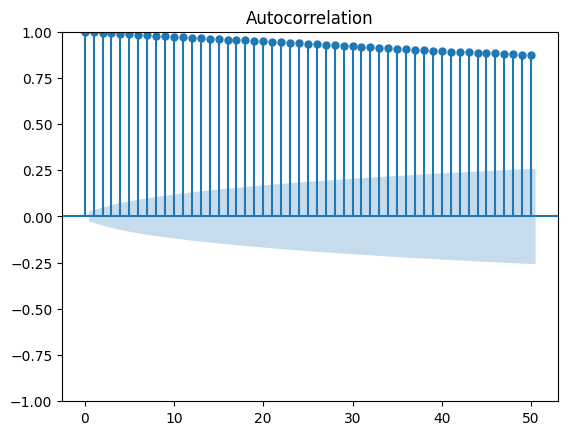

<Figure size 1400x600 with 0 Axes>

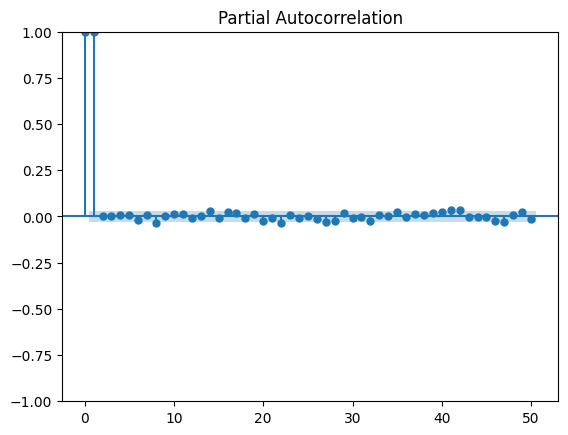

In [ ]:
# Data Visualization
# Plot stock price trends
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.title('NVIDIA Stock closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Histogram of closing prices
plt.figure(figsize=(10,5))
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Distribution of Closing Prices')
plt.show()


# Moving Averages
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['SMA_20'], label='20-day SMA', linestyle='dashed')
plt.plot(df['SMA_50'], label='50-day SMA', linestyle='dashed')
plt.plot(df['SMA_200'], label='200-day SMA', linestyle='dashed')
plt.title('Stock Price with Moving Averages')
plt.legend()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# Volatility Analysis
df['Daily Returns'] = df['Close'].pct_change()
plt.figure(figsize=(14,6))
plt.plot(df['Daily Returns'], label='Daily Returns')
plt.title('NVIDIA Stock Daily Returns')
plt.legend()
plt.show()

# Rolling Volatility
df['Rolling Volatility'] = df['Daily Returns'].rolling(window=30).std()
plt.figure(figsize=(14,6))
plt.plot(df['Rolling Volatility'], label='Rolling Volatility (30 days)')
plt.title('Stock Price Volatility Over Time')
plt.legend()
plt.show()

df['Rolling_Volatility'] = df['Close'].rolling(window=30).std()
df[['Close', 'Rolling_Volatility']].plot(subplots=True, figsize=(12,6))
plt.show()


# Seasonality Analysis
result = seasonal_decompose(df['Close'], model='multiplicative', period=252)
result.plot()
plt.show()

# Autocorrelation & Partial Autocorrelation
plt.figure(figsize=(14,6))
plot_acf(df['Close'].dropna(), lags=50)
plt.show()

plt.figure(figsize=(14,6))
plot_pacf(df['Close'].dropna(), lags=50)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 3.0324e-04
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 2.7439e-05
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 2.4287e-05
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 2.2269e-05
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 2.2394e-05
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


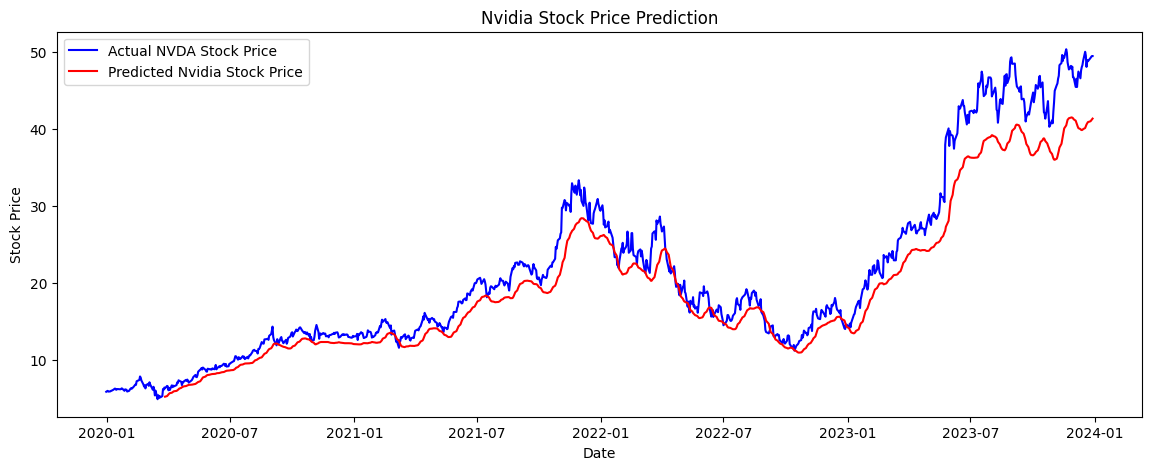

In [ ]:
data = df[['Close']]


# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training dataset
train_data = scaled_data[0:int(len(scaled_data) * 0.8)]
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])


# MODEL BUILDING

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Model Training:
# Building LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Prepare the test dataset (using the last 20% of the data)
test_data = scaled_data[int(len(scaled_data) * 0.8):]
inputs = test_data.reshape(-1, 1)

# Prepare the input data for testing
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i - 60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Prepare the dates for the predictions
# Since we have a look-back of 60 days, we need to adjust the dates accordingly
predicted_dates = data.index[int(len(data) * 0.8) + 60: int(len(data) * 0.8) + 60 + len(predictions)]

# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(data.index[int(len(data) * 0.8):], data['Close'][int(len(data) * 0.8):], color='blue', label='Actual NVDA Stock Price')
plt.plot(predicted_dates, predictions, color='red', label='Predicted Nvidia Stock Price')
plt.title('Nvidia Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
